### Ushbu ma'lumotlar amaliy ishda insonlarning o'pkalarini kassalanishi (Pnevmoniya kassaligini) aniqlashning juda ham sodda analizi ko'rsatilingan. 

#### Ushbu ma'lumotlar to'plami ayollar va bolalar tibbiyot markazidan bir yoshdan besh yoshgacha bo'lgan pediatrik bemorlarning retrospektiv kogortalaridan tanlangan.

#### Ushbu ma'lumotlar (rasmlar) dan foydalangan holda pnevmoniyani aniqlaymiz.



> Kerakli kutubxonalarni chaqirib olamiz



In [8]:
import fastai
from fastai.vision.all import *
import pandas as pd
import seaborn as sns
from pathlib import Path



> Path hamda DataBlock yasab olamiz



In [9]:
path = "/kaggle/input/pnevmoniya/train"

image_block = DataBlock(blocks = [ImageBlock, CategoryBlock], 
                        get_items=get_image_files,
                        splitter = RandomSplitter(seed = 42),
                        get_y = parent_label, 
                        item_tfms = Resize(224))

In [10]:
normal = os.listdir('/kaggle/input/pnevmoniya/train/NORMAL')
pneumonia = os.listdir('/kaggle/input/pnevmoniya/train/PNEUMONIA')

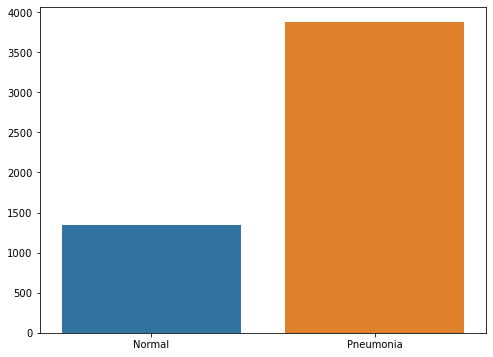

In [11]:
plt.figure(figsize = (8, 6))

sns.barplot(x = ['Normal', 'Pneumonia'], y = [len(normal), len(pneumonia)]);

##### Bu yerda Labellar nomutanosibligi mavjud bular sonini teng olgan holda (1341 ta) alohida dataset tuzib predict qilinganda natija 84.6% aniqlikni bergan edi (https://www.kaggle.com/competitions/pnevmoniya/leaderboard) lekin hozir berilgan dataset buyicha predictni amalga oshiramiz



> Data Loader yaratib olamiz



In [12]:
dls = image_block.dataloaders(path)



> Datasetdan na'munalar ko'rishimiz mumkin



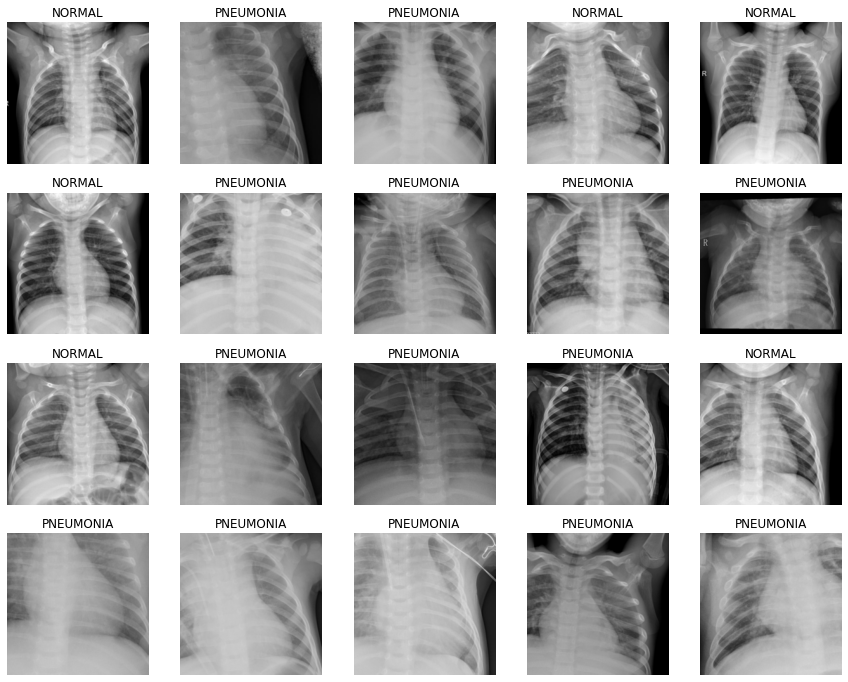

In [13]:
dls.train.show_batch(max_n = 20, nrows= 4)

### Modelni o'qitib olamiz 5 ta epoch da

In [14]:
model = vision_learner(dls, resnet152, metrics = [accuracy, Recall(), Precision()])
model.fine_tune(5)

Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth


  0%|          | 0.00/230M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,time
0,0.400323,0.314191,0.924257,0.964844,0.934426,03:14


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,time
0,0.145164,0.170696,0.965484,0.963542,0.989305,02:59
1,0.115799,0.098553,0.963567,0.985677,0.965561,02:59
2,0.060067,0.053014,0.981783,0.993490,0.981982,02:59
3,0.030098,0.038403,0.982742,0.992188,0.984496,02:58
4,0.015365,0.035393,0.985618,0.989583,0.990874,02:58


> Aniqliklarni tekshiramiz

In [22]:
interp = ClassificationInterpretation.from_learner(model)

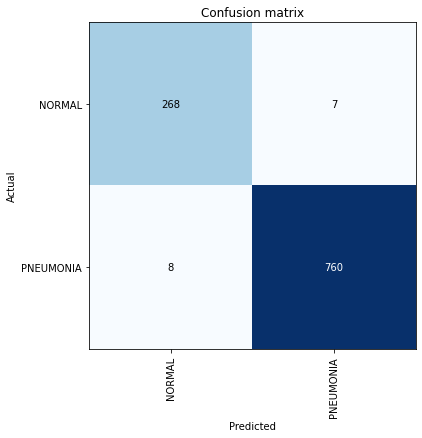

In [29]:
interp.plot_confusion_matrix(figsize = (6, 6))

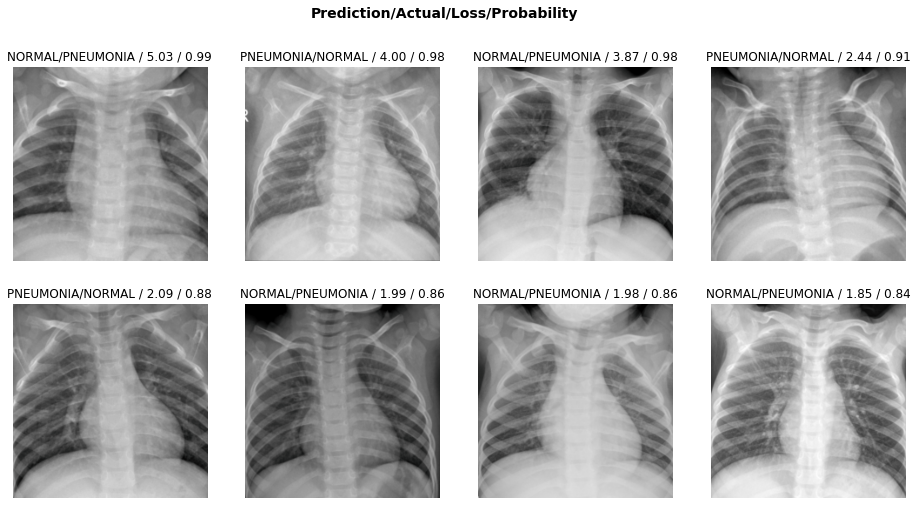

In [28]:
interp.plot_top_losses(8, nrows = 2, figsize = (16, 8))



> Kagglega jo'natiladigan sample solution fileni yuklab olamiz



In [15]:
sample_solution = pd.read_csv("/kaggle/input/pnevmoniya/sample_solution.csv")
sample_solution.head()

,id,labels
0,test_img_10001.jpeg,0
1,test_img_10002.jpeg,0
2,test_img_10003.jpeg,0
3,test_img_10004.jpeg,0
4,test_img_10005.jpeg,0




> Qiymatlar va ramlarni moslab chiqamiz va yukuniy natijani olamiz



In [16]:
j = 0
for i in sample_solution['id'].values:
  img = PILImage.create(f"/kaggle/input/pnevmoniya/test/{i}")
  label , pred_id, prob = model.predict(img)
  sample_solution.iloc[j, 1] = label
  j += 1

In [17]:
sample_solution.head()

,id,labels
0,test_img_10001.jpeg,PNEUMONIA
1,test_img_10002.jpeg,NORMAL
2,test_img_10003.jpeg,NORMAL
3,test_img_10004.jpeg,PNEUMONIA
4,test_img_10005.jpeg,NORMAL



> Map orqali qiymatlarni numeric category ko'rinishga o'tkazamiz va natijani saqlab olamiz

In [18]:
sample_solution.labels = sample_solution.labels.map({"PNEUMONIA" : 1, "NORMAL" : 0})
sample_solution.head()

,id,labels
0,test_img_10001.jpeg,1
1,test_img_10002.jpeg,0
2,test_img_10003.jpeg,0
3,test_img_10004.jpeg,1
4,test_img_10005.jpeg,0


In [20]:
sample_solution.to_csv('sample_solution_for_admit.csv', index= False)